In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import torch.nn.functional as F

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
dataset = torch.reshape(torch.from_numpy(X_train), (X_train.shape[0],3,32,32))
label = torch.flatten(torch.from_numpy(y_train))
label = to_categorical(label)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [16]:
print(x_train.shape)

torch.Size([40000, 3, 32, 32])


In [73]:
train_data = TensorDataset(x_train, y_train)
train_iter = DataLoader(train_data, batch_size = 512, shuffle=True)

test_data = TensorDataset(x_test, y_test)
test_iter = DataLoader(test_data, batch_size = 512, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
class ClassificationImage(nn.Module):
    def __init__(self):
        super(ClassificationImage,self).__init__()
        self.conv_2d_1 = nn.Conv2d(3,8,3,padding=1)
        self.max_1 = nn.MaxPool2d(2, stride=2)
        self.conv_2d_2 = nn.Conv2d(8,16,3,padding=1)
        
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(1024,32)  
        self.batch_norm_1 = nn.BatchNorm1d(32)

        self.linear_2 = nn.Linear(32,16)        
        self.batch_norm_2 = nn.BatchNorm1d(16)
        self.linear_3 = nn.Linear(16,10)        
        self.batch_norm_3 = nn.BatchNorm1d(10)


        self.softmax = nn.Softmax(dim=1)
    def forward(self,image):

        h = self.conv_2d_1(image)
        h = F.leaky_relu(h,0.01)
        h = self.max_1(h)
        
        h = self.conv_2d_2(h)
        h = F.leaky_relu(h,0.01)
        h = self.max_1(h)
        
        h = self.flatten(h)
        
        h = self.linear_1(h)
        h = F.leaky_relu(h,0.01)
        h = self.batch_norm_1(h)
        
        h = self.linear_2(h)
        h = F.leaky_relu(h,0.01)
        h = self.batch_norm_2(h)
        
        h = self.linear_3(h)

        
#         h = self.softmax(h)
        return h
model = ClassificationImage().to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
total_para = sum(p.numel() for p in model.parameters())
print(total_para)
print(model)

35006
ClassificationImage(
  (conv_2d_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2d_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=1024, out_features=32, bias=True)
  (batch_norm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=32, out_features=16, bias=True)
  (batch_norm_2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=16, out_features=10, bias=True)
  (batch_norm_3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
epochs_time = []

epochs_loss = []
epochs_acc_accuracy = []
epochs_acc_precision = []
epochs_acc_recall = []
epochs_acc_f1 = []

epochs_test_loss = []
epochs_test_acc_accuracy = []
epochs_test_acc_precision = []
epochs_test_acc_recall = []
epochs_test_acc_f1 = []

loss_list, test_loss_list = [], []

acc_f1, test_acc_f1 = [], []
acc_accuracy, test_acc_accuracy = [], []
acc_precision, test_acc_precision = [], []
acc_recall, test_acc_recall = [], []

for i in range(1000):
    model.train()
    for x,y in train_iter:
        x = x.float().to(device)
        y = y.to(device)
        
        pred = model(x)
        optimizer.zero_grad() 
        loss = loss_fn(pred, y)
        
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

        ground_truth = torch.argmax( torch.clone(y), dim=1).cpu().detach().numpy().copy()
        pred_ind = torch.argmax( torch.clone(pred), dim=1).cpu().detach().numpy().copy()

        accuracy = accuracy_score(ground_truth, pred_ind)
        acc_accuracy.append(accuracy)
        
        precision = precision_score(ground_truth, pred_ind, average= "micro")
        acc_precision.append(precision)
        
        recall = recall_score(ground_truth, pred_ind,  average='micro')
        acc_recall.append(recall)
        
        f1 = f1_score(ground_truth, pred_ind, average="micro")
        acc_f1.append(f1)

    model.eval()
    for x_test,y_test in test_iter:
        x_test = x_test.float().to(device)
        y_test = y_test.to(device)
  
        pred_test = model(x_test)
        loss_test = loss_fn(pred_test, y_test)
        test_loss_list.append(loss_test.item())
        
        ground_truth_test = torch.argmax(torch.clone(y_test), dim=1).cpu().detach().numpy().copy()
        pred_ind_test = torch.argmax(torch.clone(pred_test), dim=1).cpu().detach().numpy().copy()
    
        test_accuracy = accuracy_score(ground_truth_test, pred_ind_test)
        test_acc_accuracy.append(test_accuracy)
        
        test_precision = precision_score(ground_truth_test, pred_ind_test, average= "micro")
        test_acc_precision.append(test_precision)
        
        test_recall = recall_score(ground_truth_test, pred_ind_test,  average='micro')
        test_acc_recall.append(test_recall)
    
        test_f1 = f1_score(ground_truth_test, pred_ind_test, average="micro")
        test_acc_f1.append(test_f1)
    epochs_time.append(i)
    
    total_loss = sum(loss_list)/len(loss_list)
    test_total_loss = sum(test_loss_list)/len(test_loss_list)
    epochs_loss.append(total_loss)
    epochs_test_loss.append(test_total_loss)
    
    total_accuracy = sum(acc_accuracy)/len(acc_accuracy)
    test_total_accuracy = sum(test_acc_accuracy)/len(test_acc_accuracy)
    epochs_acc_accuracy.append(total_accuracy)
    epochs_test_acc_accuracy.append(test_total_accuracy)
    
    
    total_precision = sum(acc_precision)/len(acc_precision)
    test_total_precision = sum(test_acc_precision)/len(test_acc_precision)
    epochs_acc_precision.append(total_precision)
    epochs_test_acc_precision.append(test_total_precision)
    
    total_recall = sum(acc_recall)/len(acc_recall)
    test_total_recall = sum(test_acc_recall)/len(test_acc_recall)
    epochs_acc_recall.append(total_recall)
    epochs_test_acc_recall.append(test_total_recall)
    
    total_f1 = sum(acc_f1)/len(acc_f1)
    test_total_f1 = sum(test_acc_f1) / len(test_acc_f1)
    epochs_acc_f1.append(total_f1)
    epochs_test_acc_f1.append(test_total_f1)
    if i % 10 == 0:
        print(f"Epochs: {i}, loss: {total_loss}, test loss: {test_total_loss}")
        print(f"Accuracy acc: {total_accuracy}, test accuracy acc: {test_total_accuracy}")
        print(f"Accuracy precision: {total_precision}, test accuracy precision: {test_total_precision}")
        print(f"Accuracy recall: {total_recall}, test accuracy recall: {test_total_recall}")
        print(f"Accuracy f1: {total_f1}, test accuracy f1: {test_total_f1}")
        print(f"=======================================================================")

Epochs: 0, loss: 1.981846021700509, test loss: 1.9306379556655884
Accuracy acc: 0.2786540743670886, test accuracy acc: 0.3671875
Accuracy precision: 0.2786540743670886, test accuracy precision: 0.3671875
Accuracy recall: 0.2786540743670886, test accuracy recall: 0.3671875
Accuracy f1: 0.2786540743670886, test accuracy f1: 0.3671875
Epochs: 10, loss: 1.5271020389673213, test loss: 1.725640058517456
Accuracy acc: 0.4454046497410817, test accuracy acc: 0.4069602272727273
Accuracy precision: 0.4454046497410817, test accuracy precision: 0.4069602272727273
Accuracy recall: 0.4454046497410817, test accuracy recall: 0.4069602272727273
Accuracy f1: 0.4454046497410817, test accuracy f1: 0.4069602272727273
Epochs: 20, loss: 1.4103698846875652, test loss: 1.6529547146388464
Accuracy acc: 0.4900848591018686, test accuracy acc: 0.4334077380952381
Accuracy precision: 0.4900848591018686, test accuracy precision: 0.4334077380952381
Accuracy recall: 0.4900848591018686, test accuracy recall: 0.4334077380

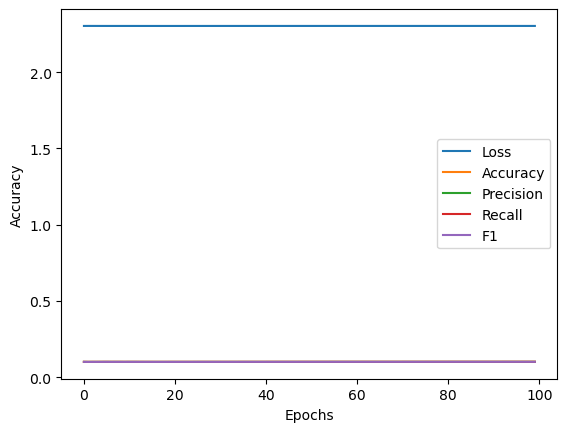

In [151]:
plt.plot(epochs_time, epochs_loss, label="Loss")
plt.plot(epochs_time, epochs_acc_accuracy, label="Accuracy")
plt.plot(epochs_time, epochs_acc_precision, label="Precision")
plt.plot(epochs_time, epochs_acc_recall, label="Recall")
plt.plot(epochs_time, epochs_acc_f1, label="F1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs_time, epochs_test_loss, label="Test loss")
plt.plot(epochs_time, epochs_test_acc_accuracy, label="Test accuracy")
plt.plot(epochs_time, epochs_test_acc_precision, label="Test precision")
plt.plot(epochs_time, epochs_test_acc_recall, label="Test recall")
plt.plot(epochs_time, epochs_test_acc_f1, label="Test f1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
data = {
    "loss": epochs_loss,
    "accuracy_acc": epochs_acc_gcn_accuracy,
    "accuracy_precision":epochs_acc_gcn_precision,
    "accuracy_recall": epochs_acc_gcn_recall,
    "accuracy_f1": epochs_acc_gcn_f1,
    
    "test_loss": epochs_test_loss_gcn,
    "test_accuracy_acc":epochs_test_acc_gcn_accuracy,
    "test_accuracy_precision":epochs_test_acc_gcn_precision,
    "test_accuracy_recall":epochs_test_acc_gcn_recall,
    "test_accuracy_f1":epochs_test_acc_gcn_f1
}
ga = pd.DataFrame(data)
ga.to_csv("gcn_hockey.csv")
torch.save(model.state_dict(), 'model_gcn_hockey.pth')

In [101]:
print(256*256*3)

196608
